<a href="https://colab.research.google.com/github/RunjiaChen/imageweek/blob/main/TP_Image_Registration_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image registration

**Goal**: The goal of this notebook is to implement the algorithms seen today for pixel-based image registration. Please complete the code where you see **XXXXXXXXXXXXXX**

If you can't take pictures, you can use two pictures of a hand provided (see below).

Otherwise, you can take two pictures of your hand or another object in two different positions. Please keep the same topology i.e., do not bend or stick together two fingers for instance.


In [4]:
if 'google.colab' in str(get_ipython()):
  from googledrivedownloader import download_file_from_google_drive
  download_file_from_google_drive(file_id='1XpgGRo839pBwIhb6h77xoG-NtHEg2DVd',
  dest_path='./Source.jpg')


  download_file_from_google_drive(file_id='12FKfLjKreAksI3rEcDx4_oEn3qjAzEua',
  dest_path='./Target.jpg')
else:
  print('You are not using Colab. Please define working_dir with the relative/absolute path to the folder where you downloaded the data')

# Please modify working_dir only if you are using your Anaconda (and not Google Colab)
# You should write the path to the directory that contains the data (Source.jpg and Target.jpg)
# If you have unzipped the folder of the lab and started the .ipynb from there, then workingDir='./data/' should work
workingDir='./'

We will use the skimage library to read and resize images:

In [3]:
from skimage.io import imread
from skimage.transform import resize

import matplotlib.pyplot as plt
from numpy import linalg as LA
import numpy as np

## Defining the transformation model

The first thing to do is to create a function that creates the transformation matrix T. Please complete the following function following the rules explained in the header of the function. Use the lecture slides on eCampus for guidance on how to build this matrix.

In [5]:
phi, psi = np.deg2rad(30), np.deg2rad(60)
Sh = [[1, np.tan(phi), 0], [np.tan(psi), 1, 0], [1, 1, 1]]
Sh = np.array(Sh)
print(Sh)

[[1.         0.57735027 0.        ]
 [1.73205081 1.         0.        ]
 [1.         1.         1.        ]]


In [6]:
def Tmatrix(scale=(1,1), rotationAngle=0, shearAngles=(0,0),translation=(0,0),elation=(0,0),reflection=(False,False)):
    '''
    Transformation matrix defined as the composition of 6 possible geometric
    transformations: Reflection (Re), Rotation (R), Scaling (S), Shear (Sh),
    Translation (T) and Elation (E).
    For the linear transformation part, we assume this composition:
        A = Re * R * S * Sh

    Inputs:
            scale: is a tuple with sx and sy (two scalar values)
            rotationAngle: is an angle in degrees (scalar value)
            shearAngles: is a tuple with the two shear angles in degrees (scalar value)
            translation: is a tuple with tx and ty (scalar values)
            elation: is a tuple containing the elation part (scalar values)
            reflection: is a tuple of Boolean values indicating wheter to reflect with respect to x and y axis

    Output:
            T: the 3x3 transformation matrix (homogeneous coordinates)
    '''

    if len(scale) != 2:
        raise ValueError("scale should be a tuple of length 2")
    if len(shearAngles)!= 2:
        raise ValueError("shearAngles should be a tuple of length 2")
    if len(translation)!= 2:
        raise ValueError("translation should be a tuple of length 2")
    if len(elation)!= 2:
        raise ValueError("elation should be a tuple of length 2")
    if len(reflection)!= 2:
        raise ValueError("reflection should contain two boolean values")
    if type(reflection[0])!= bool or type(reflection[1]) != bool:
        raise ValueError("reflection should contain two boolean values")
    if np.ndim(rotationAngle) != 0:
        raise ValueError("rotationAngle should be a scalar")

    # transform angles from degrees to radians
    phi, psi = np.deg2rad(shearAngles[0]), np.deg2rad(shearAngles[1])
    rotationAngle = np.deg2rad(rotationAngle)

    # define transformation parameters
    Sh = np.array([[1, np.tan(phi), 0], [np.tan(psi), 1, 0], [0, 0, 1]])

    Sx, Sy = scale
    S = np.array([[Sx, 0, 0], [0, Sy, 0], [0, 0, 1]])

    R = np.array([[np.cos(rotationAngle), -np.sin(rotationAngle), 0],
                  [np.sin(rotationAngle), np.cos(rotationAngle), 0],
                  [0, 0, 1]])

    rx, ry = 1, 1
    if reflection[0]:
      rx = -rx
    if reflection[1]:
      ry = -ry

    Re = np.array([[rx, 0, 0], [0, ry, 0], [0, 0, 1]])

    tx, ty = translation
    # The variable T was previously defined as a translation matrix, but the final output variable is also T.
    # The final T should combine all transformations.

    # Compute the linear transformation part: A = Re * R * S * Sh
    linear_transformation_matrix = Re @ R @ S @ Sh

    # Construct the final 3x3 transformation matrix T
    # T combines the linear part, translation, and elation components.
    T = np.array([
        [linear_transformation_matrix[0, 0], linear_transformation_matrix[0, 1], tx],
        [linear_transformation_matrix[1, 0], linear_transformation_matrix[1, 1], ty],
        [elation[0],                         elation[1],                         1]
    ])

    return T

Test here, your function.

In [7]:
## Define Transformation
T=Tmatrix(scale=(1,1), rotationAngle=40, shearAngles=(0,0),translation=(0,0),elation=(0,0),reflection=(False,False))

Next, we need to create a function that applies the previously created transformation matrix. We will need to apply it either to 2D points, seen as a [Nx2] numpy array where N is the number of points, or to image coordinates, modeled as a [2xNxM] Numpy array where N and M are the number of rows and columns of the image respectively:

In [8]:
def applyTransformation(T, points=None, coords=None):
    '''
    Apply geometric transformation to points or image coordinates.
    Transformation is defined by a 3x3 matrix

    Inputs:
        points: Nx2 Numpy array of points
        coordinates: 2xNxM Numpy array of image coordinates
        T: 3x3 matrix trasformation

    Output:
        pm: Nx2 points after transformation
        cm: 2xNxM image coordinates after transformation
    '''
    if points is None and coords is None:
        raise ValueError("Error ! You should provide points and/or coords")

    if points is not None:
        N,d = points.shape
        if d != 2 and N==2:
            print('WARNING ! points should be an array of dimension Nx2'+
                  ' Transposing the array')
            points=points.T
            N,d = points.shape

        if d != 2:
            raise ValueError("Error ! Function works only with 2D points")

        # Transform points into homogeneous coordinates (adding one...)
        # Hint: Use np.insert
        points_homogeneous = np.insert(points, 2, 1, axis=1)

        # Apply the transformation
        # The result should be an Nx3 matrix, where each row is a transformed point
        transformed_points = (T @ points_homogeneous.T).T

        # If homography, divide first two coordinates by the last one
        transformed_points_normalized = transformed_points[:, :2] / transformed_points[:, 2:]

        # Go back to standard (non-homogeneous) coordinates (remove the trailing column of ones)
        pm=transformed_points_normalized

    else:
        pm=None

    if coords is not None:
        d,N,M = coords.shape

        if d != 2:
            raise ValueError("Error ! Function works only with 2D coordinates")

        p = coords.reshape((2,N*M)).T # reshape coordinates as Nx2 list of points

        # Transform points into homogeneous coordinates (adding one...)
        # Hint: use np.insert
        p_homogeneous = np.insert(p, 2, 1, axis=1)

        # Apply the transformation
        # The result should be an Nx3 matrix, where each row is a transformed point
        transformed_p = (T @ p_homogeneous.T).T

        # If homography, divide first two coordinates by the last one
        transformed_p_normalized = transformed_p[:, :2] / transformed_p[:, 2:]

        # Go back to standard coordinates (remove the trailing column of ones),
        # and take the transpose to make pm a (2,N*M) array
        pm = transformed_p_normalized.T

        cm = pm.reshape((2,N,M))

    else:
        cm =None

    return pm,cm

## Applying transformations to point sets

Now, we can test the two functions on some data-sets of 2D points. To keep things simple, you will create two data-sets of points.

In the first one, the points will draw an ellipse (ie uniform sampling on an ellipse).
In the secon data-set, the points will draw a square (ie uniform sampling on a square).

You will then try several (at least five) different trasformations and check if your code works well.

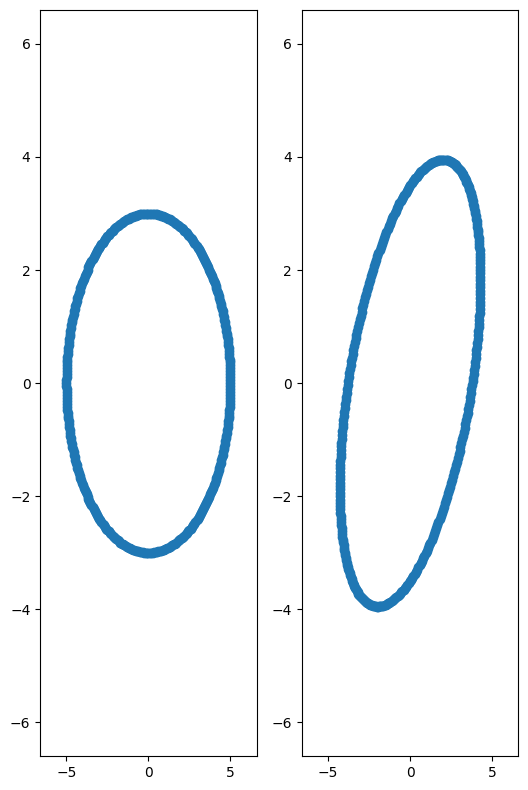

In [10]:
# Ellipse
theta = np.deg2rad(np.arange(0.0, 360.0, 1.0))
# Define semi-axes for the ellipse
a = 5
b = 3
x = a * np.cos(theta)
y = b * np.sin(theta)
points=np.array([x, y]).T

## Define Transformation
T=Tmatrix(scale=(1,1), rotationAngle=40, shearAngles=(0,0),translation=(0,0),elation=(0,0),reflection=(False,False))

## Apply trasformation
moved = applyTransformation(T, points=points)[0]

fig = plt.figure(figsize=(8, 8))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax1.scatter(points[:,0],points[:,1])
ax2.scatter(moved[:,0],moved[:,1])

minimum = np.min((ax1.get_xlim(),ax1.get_ylim(),ax2.get_xlim(),ax2.get_ylim()))
maximum = np.max((ax1.get_xlim(),ax1.get_ylim(),ax2.get_xlim(),ax2.get_ylim()))

ax1.set_xlim(minimum*1.2,maximum*1.2)
ax1.set_ylim(minimum*1.2,maximum*1.2)
ax2.set_xlim(minimum*1.2,maximum*1.2)
ax2.set_ylim(minimum*1.2,maximum*1.2)

fig.tight_layout()
plt.show()

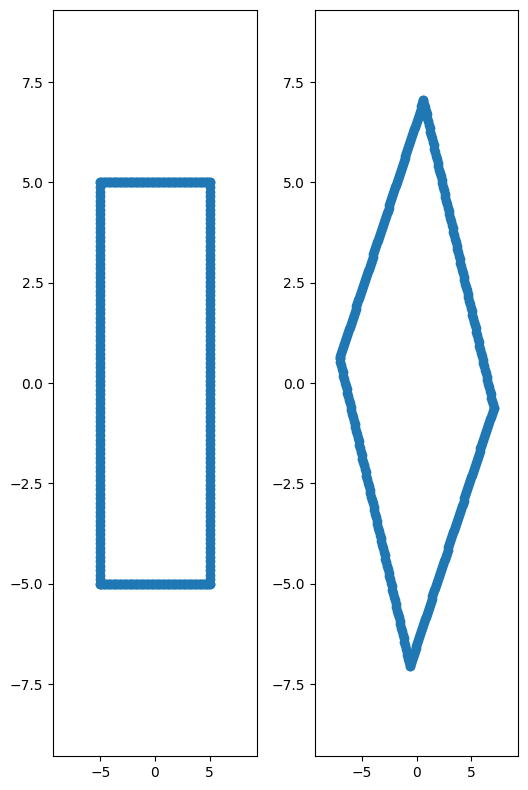

In [11]:
# Square
L = 5 # Half-side length
num_points_per_side = 90 # To get a similar density as the ellipse for visual comparison

# Generate points for each side of the square
x_coords = []
y_coords = []

# Bottom side
x_coords.extend(np.linspace(-L, L, num_points_per_side).tolist())
y_coords.extend(np.full(num_points_per_side, -L).tolist())

# Right side
x_coords.extend(np.full(num_points_per_side, L).tolist())
y_coords.extend(np.linspace(-L, L, num_points_per_side).tolist())

# Top side
x_coords.extend(np.linspace(L, -L, num_points_per_side).tolist())
y_coords.extend(np.full(num_points_per_side, L).tolist())

# Left side
x_coords.extend(np.full(num_points_per_side, -L).tolist())
y_coords.extend(np.linspace(L, -L, num_points_per_side).tolist())

x = np.array(x_coords)
y = np.array(y_coords)
points = np.array([x, y]).T

## Define Transformation
T=Tmatrix(scale=(1,1), rotationAngle=40, shearAngles=(0,0),translation=(0,0),elation=(0,0),reflection=(False,False))

## Apply trasformation
moved = applyTransformation(T, points=points)[0]

fig = plt.figure(figsize=(8, 8))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax1.scatter(points[:,0],points[:,1])
ax2.scatter(moved[:,0],moved[:,1])

minimum = np.min((ax1.get_xlim(),ax1.get_ylim(),ax2.get_xlim(),ax2.get_ylim()))
maximum = np.max((ax1.get_xlim(),ax1.get_ylim(),ax2.get_xlim(),ax2.get_ylim()))

ax1.set_xlim(minimum*1.2,maximum*1.2)
ax1.set_ylim(minimum*1.2,maximum*1.2)
ax2.set_xlim(minimum*1.2,maximum*1.2)
ax2.set_ylim(minimum*1.2,maximum*1.2)

fig.tight_layout()
plt.show()

## Applying transformations to images

Now, we can finally move to images. Here, you can load and plot the two images you have pictured. Pixel intensities are normalized in order to be float between 0 and 1.

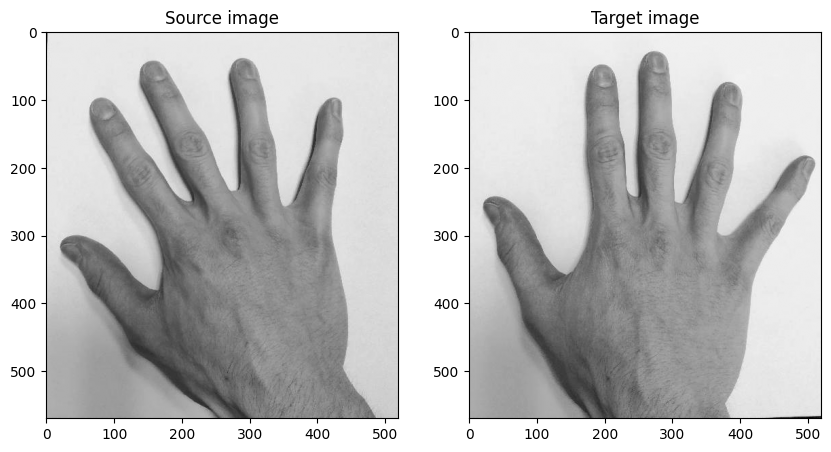

In [12]:
SourceIm = imread(workingDir + 'Source.jpg', as_gray=True)
SourceImNorm=(SourceIm - np.amin(SourceIm)) / (np.amax(SourceIm) - np.amin(SourceIm))
TargetIm = imread(workingDir + 'Target.jpg', as_gray=True)
TargetImNorm=(TargetIm - np.amin(TargetIm)) / (np.amax(TargetIm) - np.amin(TargetIm))

fig = plt.figure(figsize=(10, 10))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
ax1.imshow(SourceImNorm, cmap='gray')
ax1.set_title('Source image')
ax2.imshow(TargetImNorm, cmap='gray')
ax2.set_title('Target image')
plt.show()


In the following function, you will code the forward warping technique with point splatting.

Theoretically, an image could be associated with a coordinate chart giving the real-world coordinates of each pixel. However, the problem becomes more difficult and in many applications we do not actually have this coordinate chart. Here, you will simply consider the coordinate of a pixel as its row and column position.

In the forward warping, as seen during the lecture of this morning, the coordinates of a pixel of a source image $I$ might not be warped exactly onto the output grid. When it falls within the grid, but not on the grid, we assign (i.e., splat) the pixel intensity of $I$ to the four neighbour 'corners' of the output grid.

These contributions must be weighted and for this reason a typical solution is to create an 'accumulator'. This is an array of the same size of the output grid which quantifies the number of contributions that each corner of the output grid has received. By simply dividing by the number of contributions (output grid ./ accumulator), we obtain at each corner of the output grid an averaged estimate of the intensity of the transformed image.

In [13]:
def ForwardWarping(I,T,coords=None,outputShape=None):
    '''
    Apply forward warping to an image I based on a transformation T.
    Transformation is defined by a 3x3 matrix T

    Inputs:
        I: image to transform
        T: 3x3 matrix trasformation
        coords: coordinates of the image. If None, the coordinates of a pixel
                are automatically its row and column position
        outputShape: defines the shape of the transformed image.
                     It can be 'None', same shape as the input image I or 'BB',
                     bounding box of the transformed image I_T,  or a tuple/numpy
                     array with 4 elements (min x, max x, min y, max y)

    Output:
        J: transformed image
    '''

    if coords is None:
      coords = np.mgrid[0:I.shape[0], 0:I.shape[1]] # coordinates of the image I
      cm = applyTransformation(T,coords=coords)[1]

      if outputShape is None:
          outputShape = (0,I.shape[0],0,I.shape[1])

      elif outputShape == 'BB':
          #Find extremities bounding box
          bx=int(np.floor(np.min(cm[0,:,:])))
          ux=int(np.ceil(np.max(cm[0,:,:])))
          by=int(np.floor(np.min(cm[1,:,:])))
          uy=int(np.ceil(np.max(cm[1,:,:])))
          outputShape=(bx,ux,by,uy)

      elif isinstance(outputShape, tuple):
          if len(outputShape) != 4:
              raise ValueError("Error ! outputShape should be of length 4")

      elif isinstance(outputShape, np.ndarray):
          if len(outputShape) != 4:
              raise ValueError("Error ! outputShape should be of length 4")
      else:
          raise ValueError("Error ! outputShape should be None, 'BB' or a tuple/numpy array with 4 elements")

      # Calculate the dimensions of the output image based on outputShape
      out_rows = int(outputShape[1] - outputShape[0])
      out_cols = int(outputShape[3] - outputShape[2])

      J = np.zeros((out_rows, out_cols)) # transformed image, initialize it with an array of zeros (see np.zeros)
      acc = np.zeros((out_rows, out_cols)) # accumulator, also initialize it with an array of zeros (see np.zeros)

      for i in range(I.shape[0]):
          for j in range(I.shape[1]):

              # transformed coordinate of a pixel
              p = cm[:,i,j] # (x,y) coordinate
              x = p[0] # x
              y = p[1] # y

              # Check if point is inside outputShape
              if np.floor(x)>=outputShape[0] and np.ceil(x)<outputShape[1] and np.floor(y)>=outputShape[2] and np.ceil(y)<outputShape[3]:

                  # translate, since output image will start from (0,0)
                  # it basically shifts transformed points in the positive quadrant
                  x_shifted = x - outputShape[0]
                  y_shifted = y - outputShape[2]

                  # Look for the four corners, these are the indices of the pixels in J and acc that we will update
                  # Hint: correctly apply np.floor and np.ceil to x and y
                  bl = ( int(np.floor(x_shifted)), int(np.floor(y_shifted)) ) # bottom left
                  br = ( int(np.ceil(x_shifted)), int(np.floor(y_shifted)) ) # bottom right
                  ul = ( int(np.floor(x_shifted)), int(np.ceil(y_shifted)) ) # up left
                  ur = ( int(np.ceil(x_shifted)), int(np.ceil(y_shifted)) ) # up right

                  # Ensure indices are within bounds of J and acc
                  bl_x, bl_y = bl
                  br_x, br_y = br
                  ul_x, ul_y = ul
                  ur_x, ur_y = ur

                  # Update J and acc
                  # Add the contribution +I[i,j] to J for these four indices, and increment acc by +1 for these four indices
                  if 0 <= bl_x < out_rows and 0 <= bl_y < out_cols:
                      J[bl_x, bl_y] += I[i,j]
                      acc[bl_x, bl_y] += 1
                  if 0 <= br_x < out_rows and 0 <= br_y < out_cols:
                      J[br_x, br_y] += I[i,j]
                      acc[br_x, br_y] += 1
                  if 0 <= ul_x < out_rows and 0 <= ul_y < out_cols:
                      J[ul_x, ul_y] += I[i,j]
                      acc[ul_x, ul_y] += 1
                  if 0 <= ur_x < out_rows and 0 <= ur_y < out_cols:
                      J[ur_x, ur_y] += I[i,j]
                      acc[ur_x, ur_y] += 1

      acc[acc==0] = 1
      J = np.divide(J,acc)

    else:
        raise ValueError("Error ! Still not implemented")

    return J

Let's test your implementation of the forward warping with the source image. Test with at least 5 different transformation matrices (try different configurations). You can try a large range of parameter values for scale, rotation, shear and translation. You can try small values for elation such as 0.001 or 0.0001.

The transformation matrix T is:
 [[1.         0.08748866 0.        ]
 [0.17632698 1.         0.        ]
 [0.         0.         1.        ]]


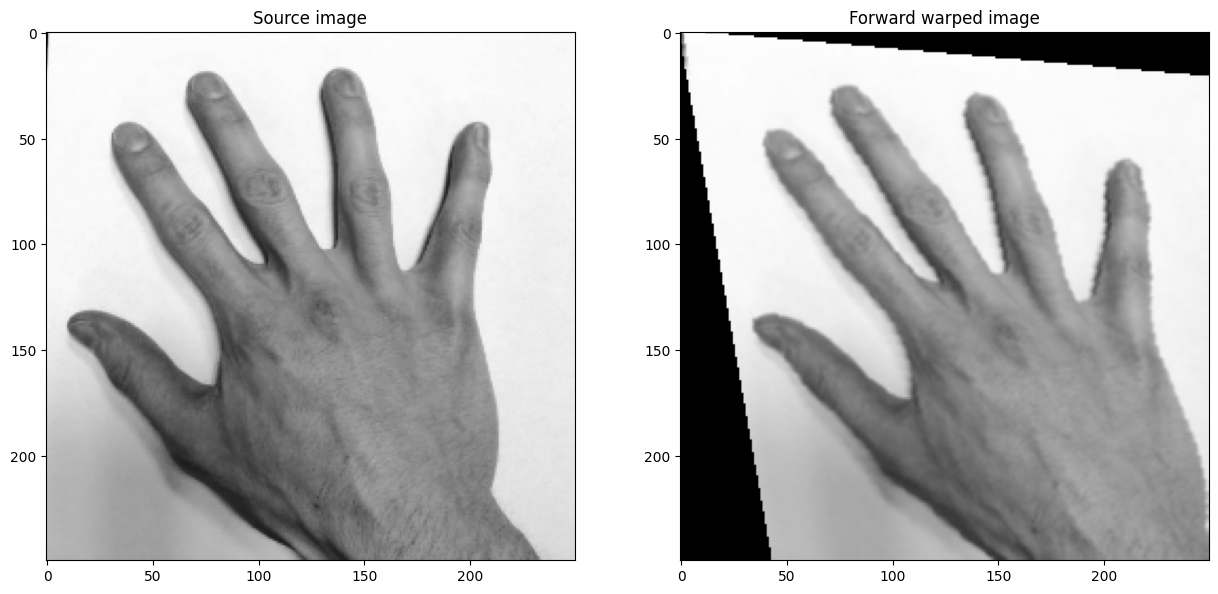

In [14]:
# Resize image (to make it faster...)
X= resize(SourceImNorm, (250,250), anti_aliasing=True)
T=Tmatrix(scale=(1,1), rotationAngle=0, shearAngles=(5,10),translation=(0,0),elation=(0,0),reflection=(False,False))
print('The transformation matrix T is:\n', T)

Xmf=ForwardWarping(X,T,outputShape=None)

fig = plt.figure(figsize=(15, 15))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
ax1.imshow(X, cmap='gray')
ax1.set_title('Source image')
ax2.imshow(Xmf, cmap='gray')
ax2.set_title('Forward warped image')
plt.show()